# PROCESS MINING FINAL PROJECT 2020-2021
## DATA PREPROCESSING
### AUTHOR: Ma Jiawei
### LECTURERS: De Leoni Massimiliano, Di Francescomarino Chiara 

### Load training data

In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer

In [3]:
log = xes_importer.apply('./BPIChallenge2011_training_0-80.xes')

parsing log, completed traces ::   0%|          | 0/912 [00:00<?, ?it/s]

Visualize the first 5 events of the first trace:

In [4]:
print(log[0][0])
print('---------')
print(log[0][1])
print('---------')
print(log[0][2])
print('---------')
print(log[0][3])
print('---------')
print(log[0][4])

{'Activity code': 'AC410100', 'concept:name': 'First outpatient consultation', 'Specialism code': 'SC61', 'Producer code': 'SRTH', 'lifecycle:transition': 'complete', 'Section': 'Section 5', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'group': 'Radiotherapy'}
---------
{'Activity code': 'AC419100', 'concept:name': 'administrative fee - the first pol', 'Specialism code': 'SC61', 'Producer code': 'SRTH', 'lifecycle:transition': 'complete', 'Section': 'Section 5', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'group': 'Radiotherapy'}
---------
{'Activity code': 'AC10107', 'concept:name': 'verlosk.-gynaec. short-out card cost', 'Specialism code': 'SC7', 'Producer code': 'SGEH', 'lifecycle:transition': 'complete', 'Section': 'Section 2', 'Number of executions': 1, 'time:timestamp': datetime.datetime(

### Encode event names as integers and check length of the traces

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
events_name = []
lengths = []
for trace in log:
    lengths += [len(trace)]
    for event in trace:
        events_name += [event['concept:name']]

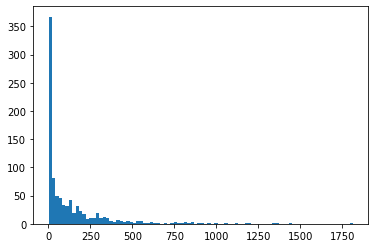

In [7]:
bins = int((max(lengths)-min(lengths))/20)
_ = plt.hist(lengths, bins=bins)

In [8]:
lengths = np.array(lengths)
print('total number of traces: ', len(lengths))
print('number of traces with length greater or equal to 20: ', np.sum(lengths>=20))
print('number of traces with length less than 20: ', np.sum(lengths<20))

total number of traces:  912
number of traces with length greater or equal to 20:  553
number of traces with length less than 20:  359


In [9]:
events_names_dict = {}
for event_name in events_name:
    if event_name not in events_names_dict:
        events_names_dict[event_name]=None

In [10]:
number_names = len(events_names_dict.keys())
print('number of diffent events: ', number_names)

number of diffent events:  582


Randomly assign integers for the events and print some examples:

In [11]:
import random
random.seed(666)
indices = list(range(1,number_names+1)) # Indices start from 1, 0 is used for padding
random.shuffle(indices)
print(indices[:30])

[338, 365, 382, 147, 565, 88, 374, 417, 409, 557, 17, 415, 405, 458, 490, 321, 451, 285, 424, 388, 507, 318, 68, 262, 540, 464, 133, 208, 440, 272]


Create a dictionary useful for encoding event names

In [12]:
for i,key in enumerate(events_names_dict.keys()):
    events_names_dict[key] = indices[i]
n = 0
for item in events_names_dict.items():
    print(item)
    n += 1
    if n>10:
        break

('First outpatient consultation', 338)
('administrative fee - the first pol', 365)
('verlosk.-gynaec. short-out card cost', 382)
('ultrasound - internal genitals', 147)
('simulator - use before megavol', 565)
('treatment time - Unit t3 - megavolt', 88)
('teletherapy - megavolt photons bestrali', 374)
('assumption laboratory', 417)
('urea', 409)
('hemoglobin photoelectric', 557)
('creatinine', 17)


### First function

In [16]:
PL = 20
def encode_trace_simple_index(trace, dictionary):  
    '''
    Input: A trace of the log and a dictionary containing (event name, integer) pairs, with diffenret int for each event.
           The function also deals with short trace of length < PL using padding. 
           
    Output: A numpy array of integers of length PL according to the dictionary. If a trace has length < PL then it's zero-padded.
    '''
    output = np.zeros(PL)
    for i, event in enumerate(trace):
        output[i] = dictionary[event['concept:name']]
        if i==PL-1:
            break
    return output

Visualize some examples:

In [17]:
sample_trace = log[3]
sample_trace_encoded = encode_trace_simple_index(sample_trace, events_names_dict)
print('length of sample_trace_encoded: ', len(sample_trace_encoded))
print('sample_trace_encoded: ', sample_trace_encoded)

length of sample_trace_encoded:  20
sample_trace_encoded:  [503. 417. 318. 321. 176. 365. 176. 176. 160. 176. 176. 176. 297. 176.
 176. 176. 365. 105. 176. 176.]


### Second function

In [18]:
import datetime
def encode_timestamp(timestamp: datetime.datetime):
    '''
    Input: datetime.datetime object contained in an event object.
    Output: [timestamp since epoch, readable format, day of the year, day of the week, month of the year,
    hour of the day in local time, minutes of the hour in local time, concatenation of hour and minutes of the day in local time]
    '''
    output = []
    
    output += [timestamp.timestamp()]
    
    output += [timestamp.isoformat()]
    
    output += [timestamp.day]
    
    output += [timestamp.weekday()]
    
    output += [timestamp.month]
    
    output += [timestamp.hour]
    
    output += [timestamp.minute]
    
    output += [str(timestamp.hour) + ':' + str(timestamp.minute)]
    
    return output

Print some examples:

In [19]:
event_time = log[3][10]['time:timestamp']
print('event_time:')
print(event_time)
print('encoded event_time:')
print(encode_timestamp(event_time))

event_time:
2005-03-29 01:00:00+02:00
encoded event_time:
[1112050800.0, '2005-03-29T01:00:00+02:00', 29, 1, 3, 1, 0, '1:0']


### Third function

In [20]:
def encode_event_simple_index_with_timestamp(event, dictionary):
    '''
    Input: event object from the log and a dictionary for the event name
    
    Output: [encoded event name, [encoded timestamp]]
    '''
    
    output = [dictionary[event['concept:name']]]
    output += [encode_timestamp(event['time:timestamp'])]
    
    return output

Print an example:

In [21]:
event= log[3][10]
print('event:')
print(event)
print('encoded event with timestamp:')
print(encode_event_simple_index_with_timestamp(event,dictionary=events_names_dict))

event:
{'Activity code': 'AC411100', 'concept:name': 'outpatient follow-up consultation', 'Specialism code': 'SC13', 'Producer code': 'SIOG', 'lifecycle:transition': 'complete', 'Section': 'Section 1', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 3, 29, 1, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'group': 'Internal Specialisms clinic'}
encoded event with timestamp:
[176, [1112050800.0, '2005-03-29T01:00:00+02:00', 29, 1, 3, 1, 0, '1:0']]


### Fourth function

In [22]:
def encode_trace_simple_index_with_timestamp(trace, dictionary):
    '''
    Input: trace object from the log and a dictionary for the event name
    
    Output: a list of length PL each element is returned by encode_event_simple_index_with_timestamp function, zero-padding is used.
    '''
    
    output = [[0,[0]]]*PL
    
    for i, event in enumerate(trace):
        output[i] = encode_event_simple_index_with_timestamp(event,dictionary)
        if i==PL-1:
            break
            
    return output

Print an example trace with length < PL:

In [23]:
trace= log[33]
print('trace:')
print(event)
print('encoded trace with timestamp:')
print(encode_trace_simple_index_with_timestamp(trace,dictionary=events_names_dict))

trace:
{'Activity code': 'AC411100', 'concept:name': 'outpatient follow-up consultation', 'Specialism code': 'SC13', 'Producer code': 'SIOG', 'lifecycle:transition': 'complete', 'Section': 'Section 1', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 3, 29, 1, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'group': 'Internal Specialisms clinic'}
encoded trace with timestamp:
[[31, [1106866800.0, '2005-01-28T00:00:00+01:00', 28, 4, 1, 0, 0, '0:0']], [417, [1117407600.0, '2005-05-30T01:00:00+02:00', 30, 0, 5, 1, 0, '1:0']], [383, [1117407600.0, '2005-05-30T01:00:00+02:00', 30, 0, 5, 1, 0, '1:0']], [321, [1117407600.0, '2005-05-30T01:00:00+02:00', 30, 0, 5, 1, 0, '1:0']], [176, [1117407600.0, '2005-05-30T01:00:00+02:00', 30, 0, 5, 1, 0, '1:0']], [105, [1121900400.0, '2005-07-21T01:00:00+02:00', 21, 3, 7, 1, 0, '1:0']], [202, [1123542000.0, '2005-08-09T01:00:00+02:00', 9, 1, 8, 1, 0, '1:0']], [559, [1123542000.0, '2005-08-09T01:00:00+02:00', 9, 1, 8, 1,

### Create training and test dataset using simple encoding

In [24]:
n = len(lengths)
X_train = np.empty(shape=(n,PL))
Y_train = np.empty(shape=n)
for i, trace in enumerate(log):
    encoded_trace = encode_trace_simple_index(trace, events_names_dict)
    if trace.attributes['label']=='false':
        label = 0
    else:
        label = 1
    X_train[i] = encoded_trace
    Y_train[i] = label

Visualize some samples form the training set:

In [25]:
for i,sample in enumerate(X_train):
    print('sample:')
    print(sample)
    print('label: ', Y_train[i], '   ', 'label(from log): ', log[i].attributes['label'])
    print('---------------------------------------')
    if i==10:
        break

sample:
[338. 365. 382. 147. 338. 365. 565.  88. 374. 417. 417. 409. 557.  17.
 415. 405. 458. 490. 321. 451.]
label:  0.0     label(from log):  false
---------------------------------------
sample:
[503. 338. 365. 382. 176. 365. 176. 451. 417. 417. 417.   4. 205. 419.
  77. 323. 243. 312. 495. 208.]
label:  0.0     label(from log):  false
---------------------------------------
sample:
[503. 176. 176. 365. 176. 176. 176. 176. 160. 176. 176. 176. 365. 417.
  35. 383. 321. 176. 559. 105.]
label:  1.0     label(from log):  true
---------------------------------------
sample:
[503. 417. 318. 321. 176. 365. 176. 176. 160. 176. 176. 176. 297. 176.
 176. 176. 365. 105. 176. 176.]
label:  0.0     label(from log):  false
---------------------------------------
sample:
[382. 116. 417. 417. 417. 524.  87.  86. 409. 557.  17. 517. 415. 405.
 540. 464. 133. 312. 495. 458.]
label:  1.0     label(from log):  true
---------------------------------------
sample:
[176. 176. 176. 176. 365. 176. 451.  67

Save the data:

In [32]:
np.save('X_train',X_train)
np.save('Y_train',Y_train)

Same thing for the test dataset:

In [27]:
log_test = xes_importer.apply('./BPIChallenge2011_testing_80-100.xes')

parsing log, completed traces ::   0%|          | 0/228 [00:00<?, ?it/s]

Some event names are not occurred in the training dataset, so I add them at the existing dictionary:

In [28]:
index = max(events_names_dict.values())
for trace in log_test:
    for event in trace:
        name = event['concept:name']
        if name not in events_names_dict:
            print('A name not in training dict: ', name)
            index += 1
            events_names_dict[name] = index

A name not in training dict:  ro gel. as ass. to puncture - biopsy l
A name not in training dict:  lymf.syst. - Regional lymfeklierdissec
A name not in training dict:  339849d-toegangschir c.v.d. catheter v.
A name not in training dict:  abnormal hemoglobin including hba2
A name not in training dict:  IgG index
A name not in training dict:  albumin ratio
A name not in training dict:  CSF concentrations after immunoelectrophoresis
A name not in training dict:  Skin - Remove retention cyst
A name not in training dict:  ro gel. as ass. by inserting endoproth
A name not in training dict:  liver - resection or tumor metastasis
A name not in training dict:  lymph. syst. - Sentinel node procedure li
A name not in training dict:  plaster room ok - use
A name not in training dict:  standard material n.n.o.
A name not in training dict:  zwachtelverband sling - construction
A name not in training dict:  partial dental status
A name not in training dict:  interc.consult outpatient
A name not in tr

In [29]:
n = len(log_test)
X_test = np.empty(shape=(n,PL))
Y_test = np.empty(shape=n)
for i, trace in enumerate(log_test):
    encoded_trace = encode_trace_simple_index(trace, events_names_dict)
    if trace.attributes['label']=='false':
        label = 0
    else:
        label = 1
    X_test[i] = encoded_trace
    Y_test[i] = label

In [30]:
print(X_test.shape)
print(Y_test.shape)

(228, 20)
(228,)


In [33]:
np.save('X_test',X_test)
np.save('Y_test',Y_test)

Save dictionary in a csv file:

In [34]:
import csv
with open('events_names.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in events_names_dict.items():
        writer.writerow([key, value])

### Create training and test dataset using simple encoding with timestamp

In [35]:
n = len(log)
X_timestamp_train = np.empty(shape=(n,PL,2))
Y_timestamp_train = np.empty(shape=n)
for i, trace in enumerate(log):
    encoded_trace = encode_trace_simple_index_with_timestamp(trace, events_names_dict)
    for j, event_with_timestamp in enumerate(encoded_trace):
        X_timestamp_train[i,j] = [event_with_timestamp[0], event_with_timestamp[1][0]]#only first time representation is considered

    if trace.attributes['label']=='false':
        label = 0
    else:
        label = 1
    Y_timestamp_train[i] = label

In [36]:
for i,sample in enumerate(X_timestamp_train):
    print('sample:')
    print(sample)
    print('label: ', Y_timestamp_train[i], '   ', 'label(from log): ', log[i].attributes['label'])
    print('---------------------------------------')
    if i==10:
        break

sample:
[[3.3800000e+02 1.1047068e+09]
 [3.6500000e+02 1.1047068e+09]
 [3.8200000e+02 1.1048796e+09]
 [1.4700000e+02 1.1048796e+09]
 [3.3800000e+02 1.1048796e+09]
 [3.6500000e+02 1.1048796e+09]
 [5.6500000e+02 1.1065212e+09]
 [8.8000000e+01 1.1071260e+09]
 [3.7400000e+02 1.1071260e+09]
 [4.1700000e+02 1.1084220e+09]
 [4.1700000e+02 1.1084220e+09]
 [4.0900000e+02 1.1084220e+09]
 [5.5700000e+02 1.1084220e+09]
 [1.7000000e+01 1.1084220e+09]
 [4.1500000e+02 1.1084220e+09]
 [4.0500000e+02 1.1084220e+09]
 [4.5800000e+02 1.1084220e+09]
 [4.9000000e+02 1.1084220e+09]
 [3.2100000e+02 1.1084220e+09]
 [4.5100000e+02 1.1085948e+09]]
label:  0.0     label(from log):  false
---------------------------------------
sample:
[[5.0300000e+02 1.1047068e+09]
 [3.3800000e+02 1.1047068e+09]
 [3.6500000e+02 1.1047068e+09]
 [3.8200000e+02 1.1049660e+09]
 [1.7600000e+02 1.1049660e+09]
 [3.6500000e+02 1.1049660e+09]
 [1.7600000e+02 1.1053116e+09]
 [4.5100000e+02 1.1060892e+09]
 [4.1700000e+02 1.1060892e+09]
 [4.

In [37]:
n = len(log_test)
X_timestamp_test = np.empty(shape=(n,PL,2))
Y_timestamp_test = np.empty(shape=n)
for i, trace in enumerate(log_test):
    encoded_trace = encode_trace_simple_index_with_timestamp(trace, events_names_dict)
    for j, event_with_timestamp in enumerate(encoded_trace):
        X_timestamp_test[i,j] = [event_with_timestamp[0], event_with_timestamp[1][0]]#only first time representation is considered

    if trace.attributes['label']=='false':
        label = 0
    else:
        label = 1
    Y_timestamp_test[i] = label

In [38]:
np.save('X_timestamp_train', X_timestamp_train)
np.save('Y_timestamp_train', Y_timestamp_train)
np.save('X_timestamp_test', X_timestamp_test)
np.save('Y_timestamp_test', Y_timestamp_test)